## Estimating learning rule from converged minima

Research question: Can we predict which learning rules the network uses by just seeing the minima it reaches for various parameters initialization of the neural network?

Methodology:
- Creating the dataset:
	- Train 50 networks with the `SGD(lr=0.005, momentum=0.9)` learning rule and 50 with `Adam(lr=0.005)`. Train them for one epoch on MNIST. The network architecture is 784 -> 500 -> 10.
	- Extract the following properties for the first layer weights at convergence: principle components to reach 40% of explained variance, mean, norm, skew, std, kurtosis. This is our dataset use in the next step.
- Train classifiers:
	- Split the dataset into training and testing sets. 
	- Use train sets to train various classifiers to find which learning rule was used (2 class classification problem).
	- **Result:** We observed that we can seperate these networks with 100% accuracy.
- Visualize properties while training:
	- We plot how each of the properties change as the network gets trained for both learning rules.
	- **Finding:**: Even though all of them start at a similar point, the evolution of dynamics is very different for SGD with momentum versus Adam. Hence, it seems like there could be a lot of information about the learning rules that can be extracted from these simple properties.

Reference MNIST code: https://github.com/pytorch/examples/blob/master/mnist/main.py

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.decomposition import PCA

### Setting up network training

In [2]:
input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 1 # number of times which the entire dataset is passed throughout the model
batch_size = 64  # the size of input data took for one iteration
lr = 5e-3 # size of step
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [4]:
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
  
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [6]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).view(-1,28*28), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).view(-1,28*28), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [8]:
loss_function = nn.CrossEntropyLoss()

### Creating the dataset

In [ ]:
features_mat = []
for i in tqdm(range(100)):
    features = {}
    net = Net(input_size, hidden_size, num_classes).to(device)
    if(i%2 == 0):
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
        features['label'] = 'SGD(5e-3,0.9)'
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)
        features['label'] = 'Adam(5e-3)'
    train(net, device, train_gen, optimizer, 1)
    test_accuracy = test(net, device, test_gen)
    train_accuracy = test(net, device, train_gen)
    weights = dict(net.named_parameters())['fc1.weight'].detach().cpu().numpy()


    pca = PCA(n_components=100)
    pca.fit(weights)

    features['PCA_evr'] = pca.explained_variance_ratio_
    weights = weights.flatten()
    features['mean'] = np.mean(weights)
    features['std']= np.std(weights)
    features['kurtosis'] = stats.kurtosis(weights)
    features['skew'] = stats.skew(weights)
    features['norm'] = np.linalg.norm(weights.flatten())
    features['train_acc'] = train_accuracy
    features['test_acc'] = test_accuracy
    
    features_mat.append(features)

### Doing classification on the dataset

In [86]:
import pickle
# pickle.dump( features_mat, open( "data/features_mat.p", "wb" ) )
features_mat = pickle.load( open( "data/features_mat.p", "rb" ) )

In [107]:
import pandas as pd

In [108]:
df = pd.DataFrame(features_mat)

In [109]:
df['label'] = pd.factorize(df['label'])[0]

In [110]:
df['PCA_evr'] = df['PCA_evr'].transform(lambda k: np.where(np.cumsum(k)>0.4)[0][0])

In [111]:
df.head()

,PCA_evr,kurtosis,label,mean,norm,skew,std,test_acc,train_acc
0,68,-0.855425,0,0.001133,13.766787,0.046861,0.021959,91.61,90.968333
1,8,2.775276,1,-0.015621,66.120155,-0.346362,0.104445,96.51,96.930000
2,66,-0.851318,0,0.001073,13.757090,0.047172,0.021946,91.48,91.033333
3,8,2.767767,1,-0.015344,65.542664,-0.309255,0.103554,96.24,96.955000
4,67,-0.855538,0,0.001092,13.759649,0.052242,0.021950,91.39,91.040000


In [112]:
y = df['label'].to_numpy()
df = df.drop(['label', 'PCA_evr','test_acc','train_acc'],axis=1)
df.head()

,kurtosis,mean,norm,skew,std
0,-0.855425,0.001133,13.766787,0.046861,0.021959
1,2.775276,-0.015621,66.120155,-0.346362,0.104445
2,-0.851318,0.001073,13.757090,0.047172,0.021946
3,2.767767,-0.015344,65.542664,-0.309255,0.103554
4,-0.855538,0.001092,13.759649,0.052242,0.021950


In [113]:
X = df.to_numpy()
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33, random_state=42)

In [94]:
from sklearn import svm
SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
SVM.predict(X_test)
round(SVM.score(X_test,y_test), 4)

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1.0

In [95]:
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF.fit(X_train, y_train)
RF.predict(X_test)
round(RF.score(X,y), 4)

1.0

In [84]:
RF.feature_importances_

array([0.1 , 0.13, 0.22, 0.18, 0.14, 0.12, 0.11])

Observations:
- It seems like a lot of information is encoded in just these simple properties because we're able to classify perfectly. Next, let's visualize how these parameters change over time as the network evolves.    

### Visualizing various values as training progresses

In [141]:
net = Net(input_size, hidden_size, num_classes).to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=lr)

net.train()
property_vec = []
for batch_idx, (data, target) in enumerate(train_gen):
    data, target = data.to(device).view(-1,28*28), target.to(device)
    optimizer.zero_grad()
    output = net(data)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 50 == 0:
        weights = dict(net.named_parameters())['fc1.weight'].detach().cpu().numpy()
        pca = PCA(n_components=10)
        pca.fit(weights)
        properties = []
        properties.append(np.sum(pca.explained_variance_ratio_))
        weights = weights.flatten()
        properties.extend([np.mean(weights),np.std(weights),stats.kurtosis(weights),\
                           stats.skew(weights), np.linalg.norm(weights.flatten())])
        property_vec.append(properties)
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            1, batch_idx * len(data), len(train_gen.dataset),
            100. * batch_idx / len(train_gen), loss.item()), end='\r')

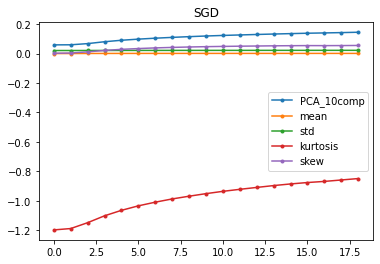

In [142]:
plt.plot(np.array(property_vec)[:,:-1], '.-')
plt.title('SGD')
plt.legend(['PCA_10comp','mean','std','kurtosis','skew'])

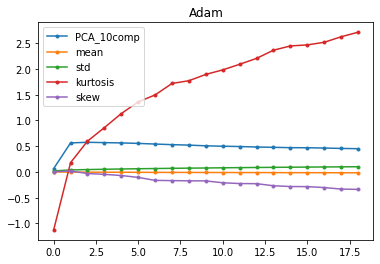

In [140]:
plt.plot(np.array(property_vec)[:,:-1], '.-')
plt.title('Adam')
plt.legend(['PCA_10comp','mean','std','kurtosis','skew'])

Observations and thoughts:
- Even though all of them start at a similar point, the evolution of dynamics is very different for SGD with momentum versus Adam. Hence, it seems like there could be a lot of information about the learning rules that can be extracted from these simple properties.
- However, the tests here are quite limited: we tried only one dataset with one learning rate and only two algorithms. It will be interesting to expand this future and check if the dynamics continue to be use as different.